## Loading the CIFAR-10 dataset

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import (layers, models)

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 6s 0us/step
Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


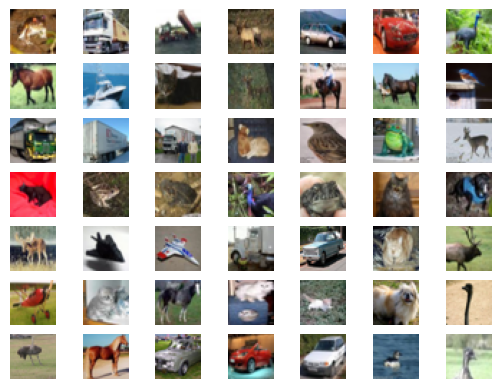

In [3]:
for i in range(49):
  plt.subplot(7, 7, 1 + i)
  plt.axis("off")
  plt.imshow(x_train[i])
plt.show()

## Discriminator

The discriminator must take a sample image from the dataset as input and output a classification prediction as to whether the sample is real or fake.

* **Inputs:** Image with three color channel and 32 x 32 pixels in size.
* **Outputs:** Binary classification, likelihood the sample is real (or fake).

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

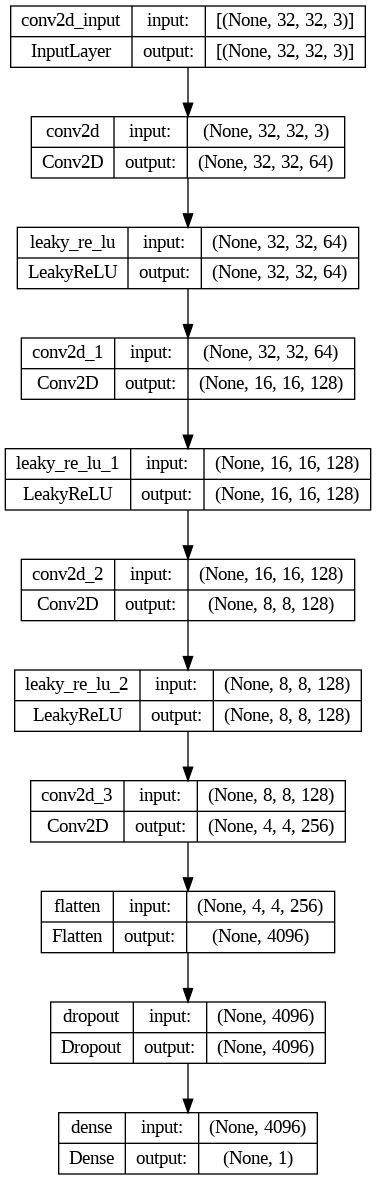

In [4]:
def define_discriminator(in_shape=(32, 32, 3)):
  model = keras.Sequential()
  model.add(layers.Conv2D(64, (3, 3), padding="same", input_shape=in_shape))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"))
  model.add(layers.Flatten())
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", 
                optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                metrics=["accuracy"])
  return model

model = define_discriminator()
model.summary()
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [5]:
def load_real_samples(x_train=x_train):
  x = x_train.astype('float32')
  x = (x - 127.5) / 127.5
  return x

In [6]:
# Generate real samples
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0, dataset.shape[0], n_samples)
  x = dataset[ix]
  y = np.ones((n_samples, 1))
  return x, y

In [7]:
# Generate fake samples
def generate_fake_samples(n_samples):
  x = np.random.rand(32 * 32 * 3 * n_samples)
  x = -1 + x * 2
  x = x.reshape((n_samples, 32, 32, 3))
  y = np.zeros((n_samples, 1))
  return x, y

In [8]:
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch / 2)
  for i in range(n_iter):
    x_real, y_real = generate_real_samples(dataset, half_batch)
    _, real_acc = model.train_on_batch(x_real, y_real)
    x_fake, y_fake = generate_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(x_fake, y_fake)
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [9]:
model = define_discriminator()
dataset = load_real_samples()
train_discriminator(model, dataset)

>1 real=22% fake=0%
>2 real=89% fake=30%
>3 real=77% fake=53%
>4 real=78% fake=72%
>5 real=73% fake=100%
>6 real=88% fake=100%
>7 real=75% fake=100%
>8 real=78% fake=100%
>9 real=86% fake=100%
>10 real=88% fake=100%
>11 real=94% fake=100%
>12 real=94% fake=100%
>13 real=95% fake=100%
>14 real=98% fake=100%
>15 real=95% fake=100%
>16 real=97% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


## Generator

In [10]:
def define_generator(latent_dim):
  model = keras.Sequential()
  n_nodes = 256 * 4 * 4
  model.add(layers.Dense(n_nodes, input_dim=latent_dim))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Reshape((4, 4, 256)))
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Conv2D(3, (3, 3), activation="tanh", padding="same"))
  return model

In [11]:
latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [12]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

In [13]:
def generate_fake_samples(g_model, latent_dim, n_samples):
  x_input = generate_latent_points(latent_dim, n_samples)
  x = g_model.predict(x_input)
  y = np.zeros((n_samples, 1))
  return x, y

2/2 [==============================] - 0s 111ms/step


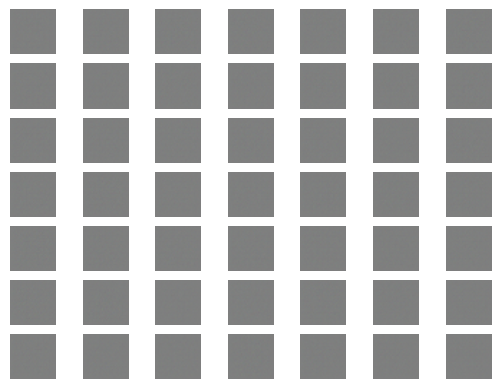

In [14]:
latent_dim = 100
model = define_generator(latent_dim)
n_samples = 49
x, _ = generate_fake_samples(model, latent_dim, n_samples)
# Scale pixel values from [-1, 1] to [0, 1]
x = (x + 1) / 2.0
for i in range(n_samples):
  plt.subplot(7, 7, 1 + i)
  plt.axis("off")
  plt.imshow(x[i])
plt.show()

## Train the Generator

In [15]:
def define_gan(g_model, d_model):
  d_model.trainable = False
  model = keras.Sequential()
  model.add(g_model)
  model.add(d_model)
  model.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
  return model

In [16]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


## Evaluation parameters for GAN

In [17]:
def save_plot(examples, epoch, n=7):
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i])
  filename = 'generator_model_%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()

In [18]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
  x_real, y_real = generate_real_samples(dataset, n_samples)
  _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  save_plot(x_fake, epoch)
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

## Train GAN

In [19]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  batch_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs):
    for j in range(batch_per_epoch):
      x_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(x_real, y_real)
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(x_fake, y_fake)
      x_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % 
       (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

## Using the Generator Model

4/4 [==============================] - 0s 55ms/step


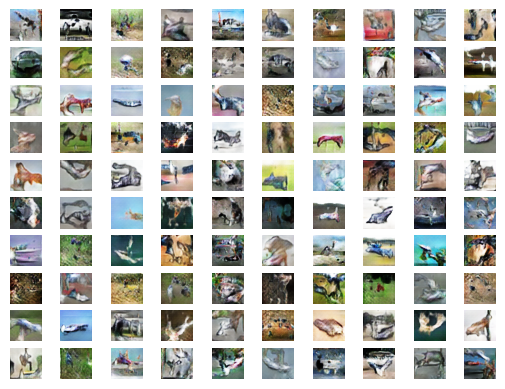

In [23]:
def generate_latent_points(latent_dim, n_samples):
  x_input = np.random.randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

def save_plot(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis("off")
    plt.imshow(examples[i, :, :])
  plt.show()

model = keras.models.load_model('generator_model_070.h5')
latent_points = generate_latent_points(100, 100)
x = model.predict(latent_points)
x = (x + 1) / 2.0
save_plot(x, 10)

## Experiment with latent space

1/1 [==============================] - 0s 123ms/step


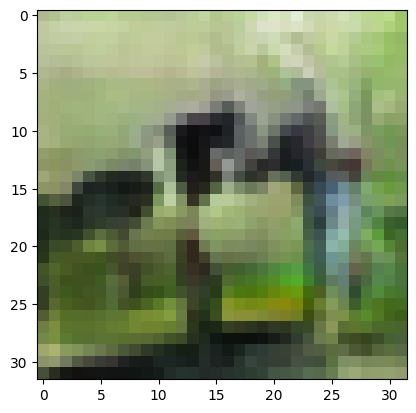

In [24]:
vector = np.asarray([[0.75 for _ in range(100)]])
x = model.predict(vector)
# Scale from [-1, 1] to [0, 1]
x = (x+1) / 2.0
plt.imshow(x[0, :, :])
plt.show()